# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [2]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [3]:
import pandas as pd

df = pd.DataFrame(newsgroupsdocs, columns=["text"])
df.head()


,text
0,\n\nI am sure some bashers of Pens fans are pr...
1,My brother is in the market for a high-perform...
2,\n\n\n\n\tFinally you said what you dream abou...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...
4,1) I have an old Jasmine drive which I cann...


In [4]:
import re

def preprocess(doc):
    # minúsculas
    doc = doc.lower()
    # solo letras y espacios
    doc = re.sub(r'[^a-z\s]', ' ', doc)
    # separar en tokens
    tokens = doc.split()
    # quitar palabras demasiado cortas o demasiado largas (ruido)
    tokens = [t for t in tokens if 3 <= len(t) <= 15]
    # volver a unir
    return " ".join(tokens)

df["prep"] = df["text"].apply(preprocess)
df["prep"].head()



0    sure some bashers pens fans are pretty confuse...
1    brother the market for high performance video ...
2    finally you said what you dream about mediterr...
3    think the scsi card doing the dma transfers no...
4    have old jasmine drive which cannot use with n...
Name: prep, dtype: object

In [5]:
docs = [d.split() for d in df["prep"]]
N = len(docs)        # número total de documentos
N


18846

In [6]:
from collections import Counter

tf_docs = [Counter(doc) for doc in docs]
tf_docs[0]   # ver el TF del primer documento


Counter({'sure': 1,
         'some': 1,
         'bashers': 1,
         'pens': 5,
         'fans': 1,
         'are': 3,
         'pretty': 1,
         'confused': 1,
         'about': 2,
         'the': 10,
         'lack': 1,
         'any': 1,
         'kind': 1,
         'posts': 1,
         'recent': 1,
         'massacre': 1,
         'devils': 2,
         'actually': 1,
         'bit': 3,
         'puzzled': 1,
         'too': 1,
         'and': 1,
         'relieved': 1,
         'however': 1,
         'going': 2,
         'put': 1,
         'end': 1,
         'non': 1,
         'pittsburghers': 1,
         'relief': 1,
         'with': 1,
         'praise': 1,
         'for': 1,
         'man': 1,
         'they': 1,
         'killing': 1,
         'those': 1,
         'worse': 1,
         'than': 2,
         'thought': 1,
         'jagr': 2,
         'just': 1,
         'showed': 1,
         'you': 1,
         'why': 1,
         'much': 1,
         'better': 1,
         'his

In [7]:
df_counts = Counter()

for tf_doc in tf_docs:
    for term in tf_doc.keys():
        df_counts[term] += 1

list(df_counts.items())[:10]   # ver algunos resultados


[('sure', 1453),
 ('some', 4332),
 ('bashers', 9),
 ('pens', 77),
 ('fans', 181),
 ('are', 7406),
 ('pretty', 749),
 ('confused', 120),
 ('about', 5067),
 ('the', 15753)]

In [8]:
import math

idf = {term: math.log(N / df_counts[term]) for term in df_counts}


In [11]:
tfidf_docs = []

for tf_doc in tf_docs:
    tfidf = {}
    for term, freq in tf_doc.items():
        tfidf[term] = freq * idf[term]   # TF * IDF
    tfidf_docs.append(tfidf)

tfidf_docs[0]   # ver TF-IDF del primer documento


{'sure': 2.5626703051964186,
 'some': 1.4702713606458204,
 'bashers': 7.646831391430482,
 'pens': 27.501252734565085,
 'fans': 4.6455589375008755,
 'are': 2.802030621879431,
 'pretty': 3.225316985249482,
 'confused': 5.056564225984656,
 'about': 2.6271035265815836,
 'the': 1.7926986646073262,
 'lack': 4.253068988255845,
 'any': 1.3731161618679262,
 'kind': 3.135971884913632,
 'posts': 4.496948438049233,
 'recent': 4.072614845636686,
 'massacre': 5.389708672513194,
 'devils': 10.92405866818564,
 'actually': 2.7922003458108073,
 'bit': 8.533900503776222,
 'puzzled': 7.646831391430482,
 'too': 2.2844964727590016,
 'and': 0.3719669063652424,
 'relieved': 7.279106611305164,
 'however': 2.6716313916418564,
 'going': 5.125340610392837,
 'put': 2.8391739790538417,
 'end': 2.972964674156156,
 'non': 3.0952964212750227,
 'pittsburghers': 9.150908788206756,
 'relief': 5.567389849750646,
 'with': 0.8488909784555517,
 'praise': 6.155176514652765,
 'for': 0.5938220331288422,
 'man': 3.30158400825989

In [12]:
# ---------------------------------------------------------
# TF-IDF usando sklearn (versión estándar)
# ---------------------------------------------------------

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    min_df=5,        # el término debe aparecer al menos en 5 documentos
    max_df=0.5       # y en como mucho el 50% de los documentos
    # puedes añadir: stop_words='english' si el profe lo permite
)

X_sklearn_tfidf = vectorizer.fit_transform(df["prep"])

tfidf_sklearn_df = pd.DataFrame(
    X_sklearn_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out()
)

tfidf_sklearn_df.head()



,aaa,aamir,aarnet,aaron,aas,aba,abandon,abandoned,abandoning,abbey,...,zones,zoo,zoom,zooming,zri,zrm,zubov,zuma,zur,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [13]:
def tfidf_query_vector(query):
    q = preprocess(query)      # usar la MISMA función de la parte 1
    tokens = q.split()

    # calcular TF del query
    from collections import Counter
    tf_q = Counter(tokens)

    # TF-IDF del query
    q_vec = {}
    for term, f in tf_q.items():
        if term in idf:                       # solo incluimos términos del vocabulario
            q_vec[term] = f * idf[term]
    return q_vec


In [14]:
import math

def cosine_similarity_dict(d1, d2):
    # producto punto
    dot = 0.0
    for t, v in d1.items():
        if t in d2:
            dot += v * d2[t]

    # norma de cada vector
    norm1 = math.sqrt(sum(v*v for v in d1.values()))
    norm2 = math.sqrt(sum(v*v for v in d2.values()))

    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot / (norm1 * norm2)


In [15]:
def ranking_tfidf(query, top_k=10):
    q_vec = tfidf_query_vector(query)
    scores = []

    for i, doc_vec in enumerate(tfidf_docs):
        s = cosine_similarity_dict(q_vec, doc_vec)
        scores.append((i, s))

    # ordenar por score descendente
    scores.sort(key=lambda x: x[1], reverse=True)

    # tomar los mejores
    top_idx = [i for i, s in scores[:top_k]]
    top_scores = [s for i, s in scores[:top_k]]

    # devolver DataFrame
    result = df.iloc[top_idx].copy()
    result["tfidf_score"] = top_scores
    return result


In [16]:
ranking_tfidf("space technology nasa", top_k=10)


,text,prep,tfidf_score
15083,Archive-name: space/addresses\nLast-modified: ...,archive name space addresses last modified dat...,0.526234
10571,Archive-name: space/net\nLast-modified: $Date:...,archive name space net last modified date netw...,0.396350
7627,There is a guy in NASA Johnson Space Center t...,there guy nasa johnson space center that might...,0.363723
16936,Archive-name: space/intro\nLast-modified: $Dat...,archive name space intro last modified date fr...,0.347277
10867,Archive-name: space/groups\nLast-modified: $Da...,archive name space groups last modified date s...,0.342961
16927,Archive-name: space/data\nLast-modified: $Date...,archive name space data last modified date onl...,0.341034
15147,There is an interesting opinion piece in the b...,there interesting opinion piece the business s...,0.338314
14142,: Has anyone ever heard of a food product call...,has anyone ever heard food product called spac...,0.332939
4246,\nEvil and good walk hand in hand. It is also...,evil and good walk hand hand also important no...,0.329332
12265,"I know it's only wishful thinking, with our cu...",know only wishful thinking with our current pr...,0.323297


## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

Algoritmo BM25:

1. Tokenización
2. Calcular longitudes de documentos y promedio de longitud
3. Calcular TF (frecuencia de término por documento)
4. Calcular DF (document frequency) e IDF de BM25
5. Definir los parámetros de BM25 (k1, b)
6. Implementar la función de score BM25 para un documento
7. Función para calcular la probabilidad para todos los documentos de la colección a partir de una query
8. Recuperar los documentos mejor puntuados (ranking)

In [17]:
import math
from collections import Counter

# 1. Tokenización de todos los documentos (usamos la columna prep)
docs_tokens = [text.split() for text in df["prep"]]
N = len(docs_tokens)

# 2. Longitud de cada documento y promedio
doc_len = [len(doc) for doc in docs_tokens]
avgdl = sum(doc_len) / N

# 3. TF por documento (frecuencia de términos)
tf_docs = [Counter(doc) for doc in docs_tokens]

# 4. DF (en cuántos documentos aparece cada término)
df_counts = Counter()
for doc_tf in tf_docs:
    for term in doc_tf.keys():
        df_counts[term] += 1

# 4b. IDF de BM25 para un término
def bm25_idf(term):
    n_qi = df_counts.get(term, 0)  # número de documentos que contienen el término
    # fórmula clásica de BM25
    return math.log((N - n_qi + 0.5) / (n_qi + 0.5) + 1)
    

# 5. Parámetros de BM25 (valores típicos)
k1 = 1.5
b = 0.75

# 6. Score BM25 para un solo documento
def bm25_score(query, doc_index):
    """
    Calcula el score BM25 de un documento dado un índice de documento.
    """
    # usamos el mismo preprocesamiento que para el corpus
    q_proc = preprocess(query)
    q_terms = q_proc.split()
    
    score = 0.0
    doc_tf = tf_docs[doc_index]
    dl = doc_len[doc_index]
    
    for term in q_terms:
        if term not in doc_tf:
            continue
        
        idf = bm25_idf(term)
        f = doc_tf[term]  # frecuencia del término en el documento
        
        # fórmula BM25
        denom = f + k1 * (1 - b + b * dl / avgdl)
        score += idf * (f * (k1 + 1)) / denom
    
    return score

# 7. Ranking BM25 para todos los documentos
def bm25_ranking(query, top_k=10):
    scores = []
    for i in range(N):
        s = bm25_score(query, i)
        scores.append((i, s))
    
    # ordenar de mayor a menor score
    scores.sort(key=lambda x: x[1], reverse=True)
    
    # quedarnos con los top_k
    top_idx = [i for i, s in scores[:top_k]]
    top_scores = [s for i, s in scores[:top_k]]
    
    # 8. Recuperar los documentos mejor puntuados
    result = df.iloc[top_idx].copy()
    result["bm25_score"] = top_scores
    return result


In [19]:
bm25_ranking("space technology nasa", top_k=10)


,text,prep,bm25_score
9555,The following press release was distributed Ap...,the following press release was distributed ap...,19.430581
14142,: Has anyone ever heard of a food product call...,has anyone ever heard food product called spac...,19.232070
15083,Archive-name: space/addresses\nLast-modified: ...,archive name space addresses last modified dat...,19.086032
522,------- Blind-Carbon-Copy\n\nTo: spacenews@aus...,blind carbon copy spacenews austen rand org ct...,17.420677
14122,NASA Headquarters distributed the following pr...,nasa headquarters distributed the following pr...,17.364755
12775,Archive-name: space/diff\n\nDIFFS SINCE LAST F...,archive name space diff diffs since last faq p...,14.837730
8197,: Announce that a reward of $1 billion would g...,announce that reward billion would the first c...,14.634479
4308,Archive-name: space/astronaut\nLast-modified: ...,archive name space astronaut last modified dat...,14.581190
10571,Archive-name: space/net\nLast-modified: $Date:...,archive name space net last modified date netw...,14.520486
7057,I am coordinating the Space Shuttle Program Of...,coordinating the space shuttle program office ...,13.911466


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

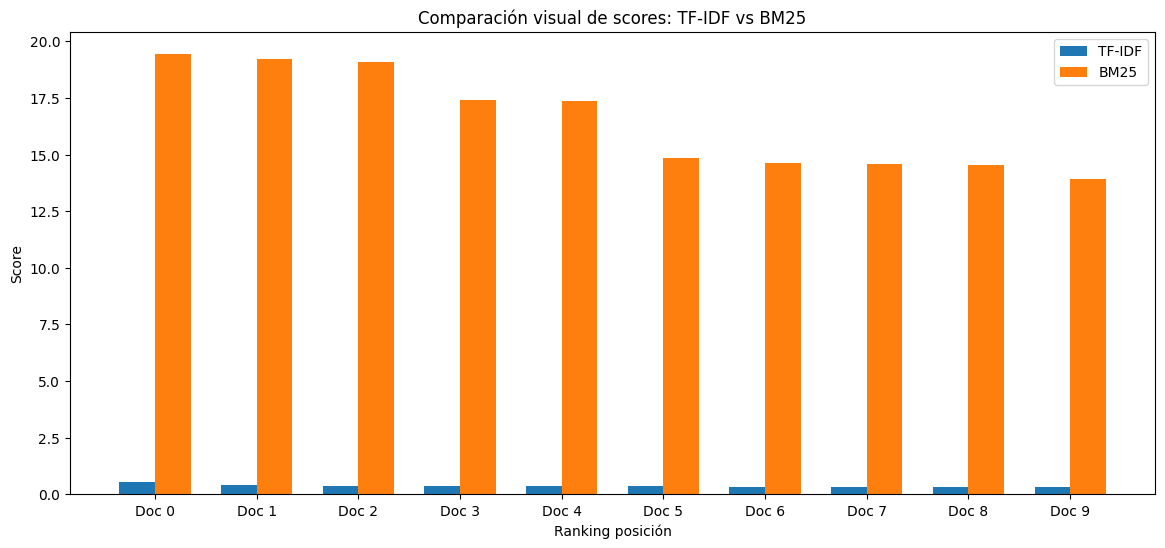

In [22]:
# ---------------------------------------------------------
# Parte 4: Comparación visual entre TF-IDF y BM25
# ---------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# --- Consulta de ejemplo ---
query = "space technology nasa"  # puedes cambiarla

# --- Ranking TF-IDF ---
tfidf_res = ranking_tfidf(query, top_k=10)[["tfidf_score"]]
tfidf_res = tfidf_res.reset_index().rename(columns={"index": "doc_id"})
tfidf_res

# --- Ranking BM25 ---
bm25_res = bm25_ranking(query, top_k=10)[["bm25_score"]]
bm25_res = bm25_res.reset_index().rename(columns={"index": "doc_id"})
bm25_res

# --- Asegurarnos de que tienen el mismo tamaño ---
k = min(len(tfidf_res), len(bm25_res))
tfidf_top = tfidf_res.iloc[:k]
bm25_top = bm25_res.iloc[:k]

# --- Crear gráfico comparativo ---
plt.figure(figsize=(14, 6))

x = np.arange(k)  # posiciones en el eje X
width = 0.35      # ancho de las barras

plt.bar(x - width/2, tfidf_top["tfidf_score"], width, label="TF-IDF")
plt.bar(x + width/2, bm25_top["bm25_score"], width, label="BM25")

plt.xlabel("Ranking posición")
plt.ylabel("Score")
plt.title("Comparación visual de scores: TF-IDF vs BM25")
plt.xticks(x, [f"Doc {i}" for i in range(k)])
plt.legend()
plt.show()


# Las diferencias entre TF-IDF y BM25 se deben principalmente a cómo consideran:

# la frecuencia del término
# la longitud del documento
# la saturación del TF
# la penalización de documentos largos



## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [23]:
# Recuperar etiquetas reales del dataset (categorías)
df["label"] = newsgroups.target
label_names = newsgroups.target_names

df[["text", "label"]].head()


,text,label
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4


In [24]:
true_label = newsgroups.target_names.index("sci.space")
query = "nasa space shuttle orbit mission"


In [25]:
def precision_at_k(ranked_indices, true_label, k=3):
    top_k = ranked_indices[:k]
    relevant = sum(df.iloc[i]["label"] == true_label for i in top_k)
    return relevant / k


In [29]:
# Ranking TF-IDF
tfidf_rank = ranking_tfidf(query, top_k=50)
tfidf_indices = tfidf_rank.index.tolist()
p3_tfidf = precision_at_k(tfidf_indices, true_label, k=3)

# Ranking BM25
bm25_rank = bm25_ranking(query, top_k=50)
bm25_indices = bm25_rank.index.tolist()
p3_bm25 = precision_at_k(bm25_indices, true_label, k=3)

print("Precision@3 TF-IDF:", p3_tfidf)
print("Precision@3 BM25  :", p3_bm25)


Precision@3 TF-IDF: 1.0
Precision@3 BM25  : 1.0
